---
title: "Pan-UKB Biology"
author: "Saikat Banerjee"
format:
  html: 
      theme: default
      code-fold: show
date: "2024-10-08"
file-modified: "2024-10-08"
abstract: "To understand the biology of latent factors, we look at the contribution of phenotypes, variants and genes to the top factors of target diseases."

---

In [1]:
import os
import re
import numpy as np
import pandas as pd
import pickle

In [2]:
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, r_regression, mutual_info_regression

In [3]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/colormann-svd"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_noRx.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all_with_desc.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df = pd.read_csv(variant_filename, sep = '\t')

nsample_filename = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data/phe2483.SampleN.tsv"
nsample_df = pd.read_csv(nsample_filename, sep = '\t')

In [4]:
methods = ["nnm", "nnm-sparse", "rpca"]
method_names = {
    "nnm" : "NNM",
    "nnm-sparse" : "NNM-Sparse",
    "rpca" : "Robust PCA"
}

res_pklfile = {
    "nnm": "nnm_model_r155872_iter1000.pkl",
    "nnm-sparse": "nnm_sparse_model_r155872_iter1000.pkl",
    "rpca": "rpca_model.pkl"
}

pca_comps = dict()
mf_comps = dict()
k = 200

for method in methods:
    comps_filename = os.path.join(result_dir, method, "noRx", "pca_comps.pkl")
    with open(comps_filename, "rb") as mfile:
        pca_comps[method] = pickle.load(mfile)
    mf_comps_filename = os.path.join(result_dir, method, "noRx", f"mf_comps_k{k}.pkl")
    with open(mf_comps_filename, "rb") as mfile:
        mf_comps[method] = pickle.load(mfile)
        
X = np.array(zscore_df.values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)

In [5]:
pheno_zindex = [int(x[1:]) for x in zscore_df.columns]
trait_df_noRx = trait_df.loc[trait_df['zindex'].isin(pheno_zindex)]
nsample_df_noRx = nsample_df.loc[trait_df_noRx.index]
trait_df_noRx.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2110 entries, 0 to 2482
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   zindex                       2110 non-null   int64  
 1   trait_type                   2110 non-null   object 
 2   phenocode                    2110 non-null   object 
 3   pheno_sex                    2110 non-null   object 
 4   coding                       267 non-null    object 
 5   modifier                     394 non-null    object 
 6   description                  2110 non-null   object 
 7   description_more             1408 non-null   object 
 8   coding_description           261 non-null    object 
 9   category                     2072 non-null   object 
 10  BIN_QT                       2110 non-null   object 
 11  n_cases_EUR                  2110 non-null   int64  
 12  n_controls_EUR               1304 non-null   float64
 13  N                      

In [9]:
# focal_disease = {
#     "opentarget_name": "triglyceride",
#     "opentarget_id": "EFO_0004530",
#     "df_query_string": "Triglycerides",
# }

# focal_disease = {
#     "opentarget_name": "",
#     "opentarget_id": "",
#     "df_query_string": "Body mass index (BMI)",
# }

# focal_disease = {
#     "opentarget_name": "arthritis",
#     "opentarget_id": "HP_0001370",
#     "df_query_string": "Rheumatoid arthritis",
# }

# focal_disease = {
#     "opentarget_name": "breast",
#     "opentarget_id": "EFO_0003869",
#     "df_query_string": "Breast cancer",
# }

# focal_disease = {
#     "opentarget_name" : "type 1 diabetes mellitus",
#     "opentarget_id": "MONDO_0005147",
#     "df_query_string": "Type 1 diabetes",
# }

focal_disease = {
    "opentarget_name" : "type 2 diabetes mellitus",
    "opentarget_id": "MONDO_0005148",
    "df_query_string": "Type 2 diabetes",
}

# focal_disease = {
#     "opentarget_name": "",
#     "opentarget_id": "",
#     "df_query_string": "Colon cancer",
# }


# trait_df_noRx.query("description == 'Body mass index (BMI)'")
trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")
# trait_df_noRx.query("description == 'Systolic blood pressure, combined automated + manual reading, adjusted by medication'")
# trait_df_noRx.query("description == 'Rheumatoid arthritis'")
# trait_df_noRx.query("description == 'Breast cancer'")
# trait_df_noRx.query("description == 'Cancer of prostate'")

,zindex,trait_type,phenocode,pheno_sex,coding,modifier,description,description_more,coding_description,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,filename,aws_link,estimates.final.h2_observed,long_description,short_description
459,460,phecode,250.2,both_sexes,NaN,NaN,Type 2 diabetes,NaN,NaN,endocrine/metabolic,BIN,22768,396181.0,418949,43061.32254,phecode-250.2-both_sexes.tsv.bgz,https://pan-ukb-us-east-1.s3.amazonaws.com/sum...,0.0484,Type 2 diabetes,Type 2 diabetes


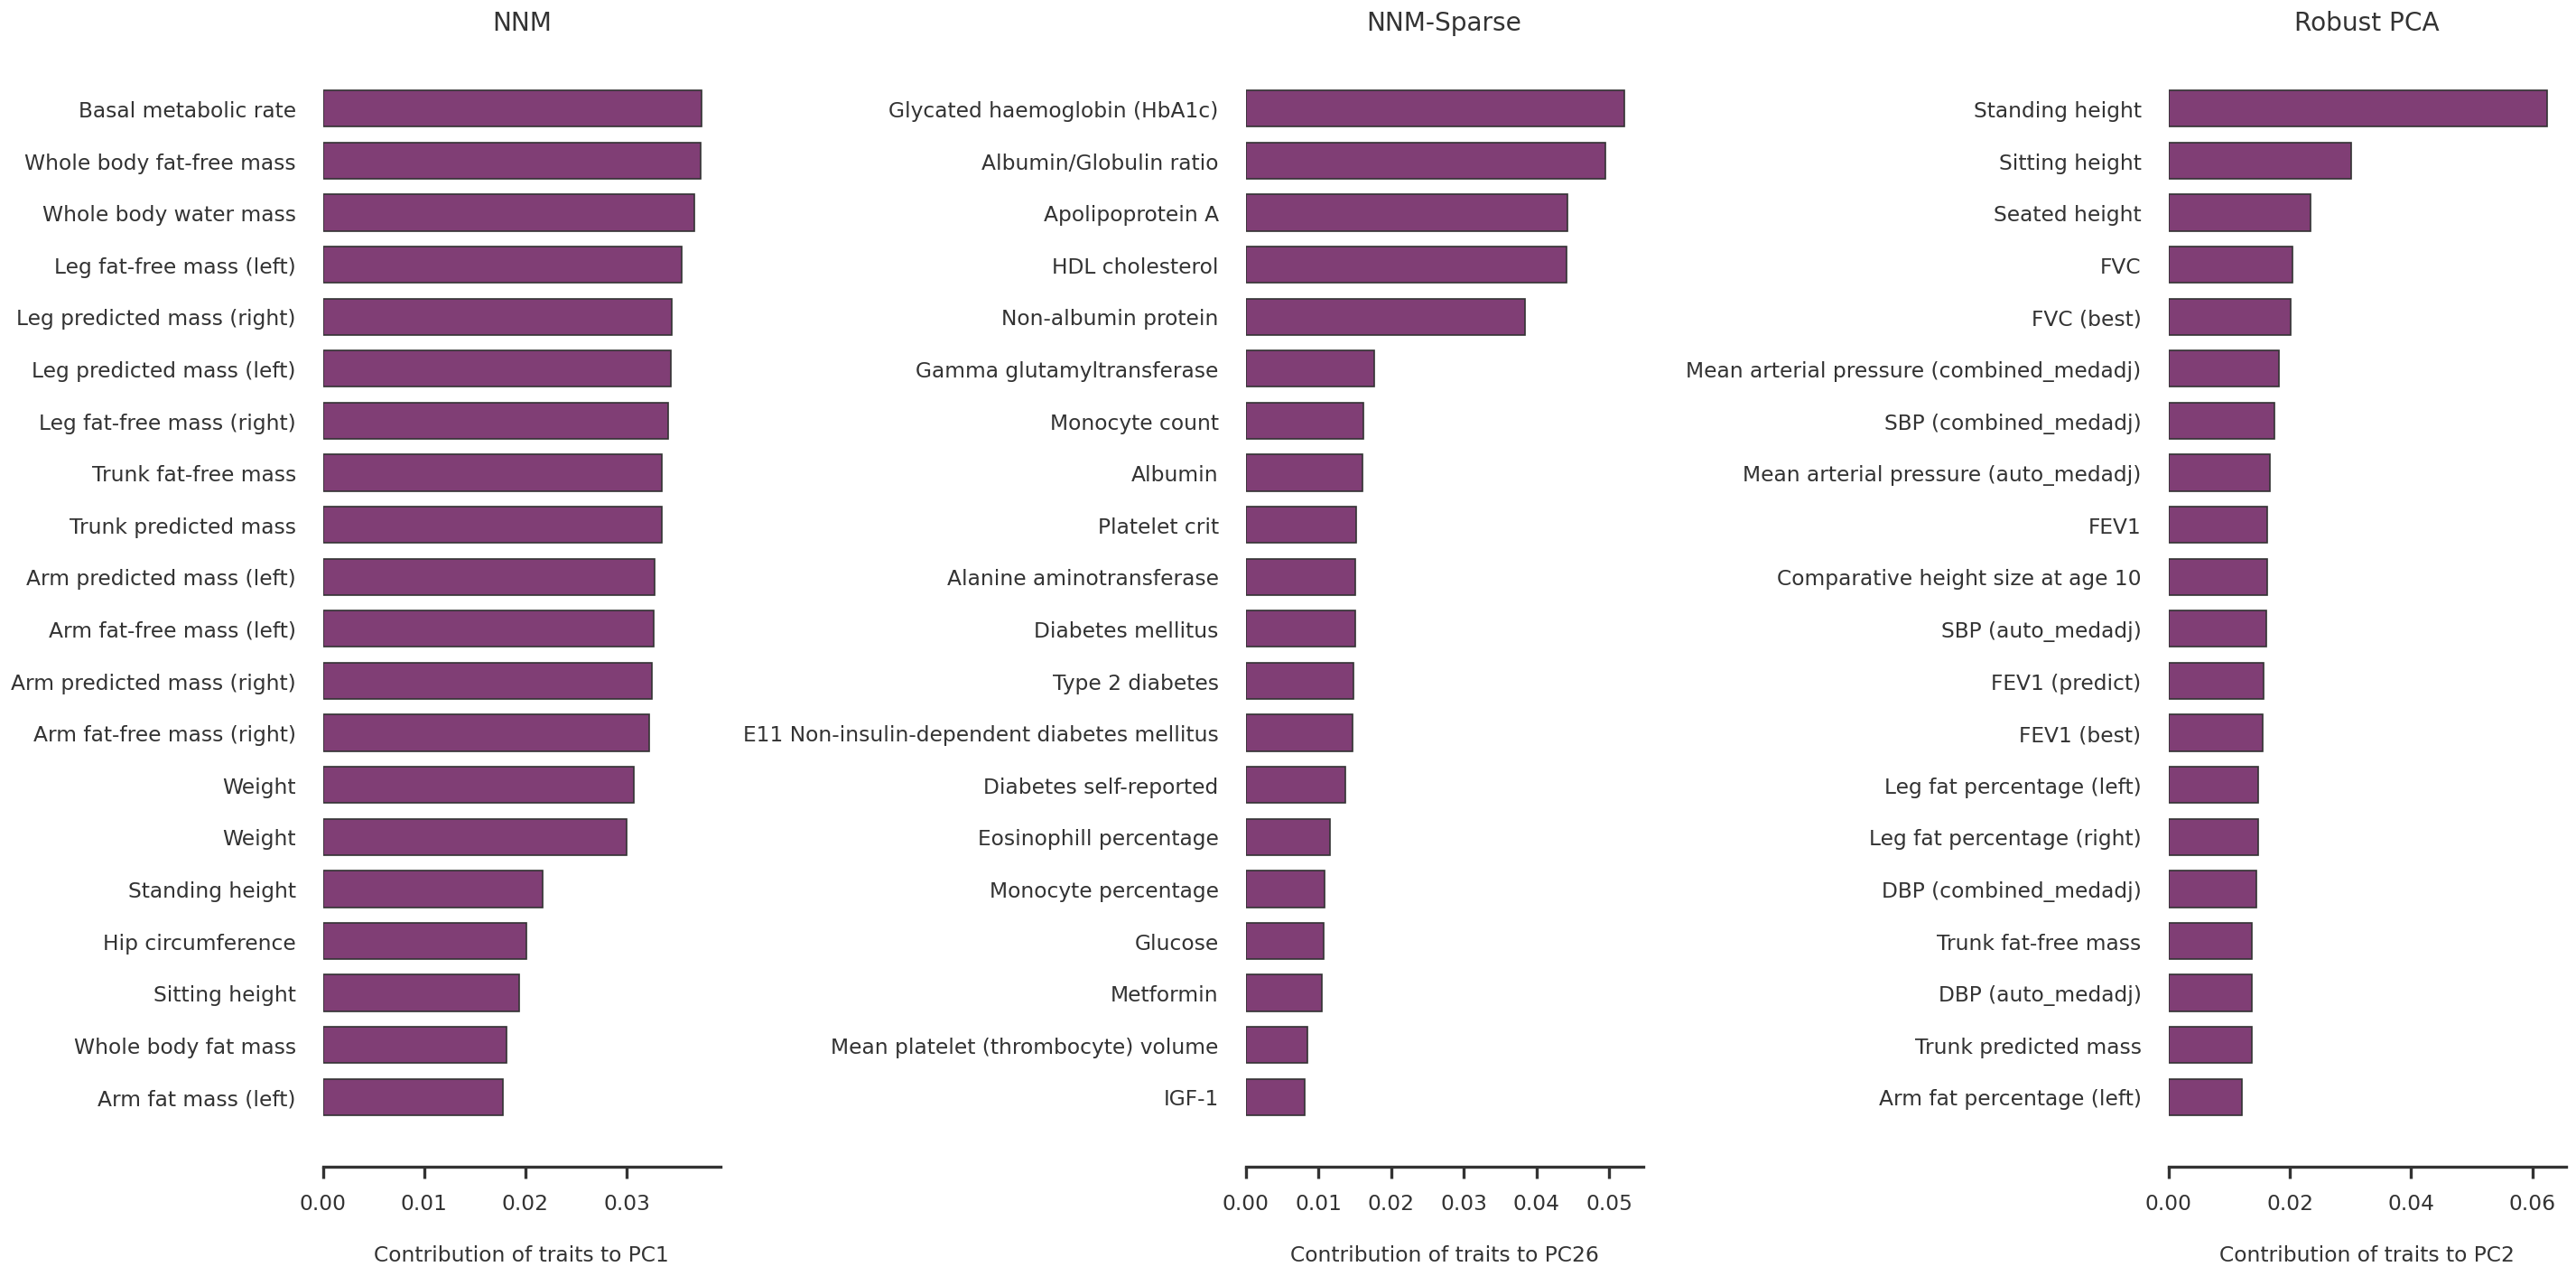

In [12]:
zindex = trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")["zindex"].values[0]

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

fig = plt.figure(figsize = (24, 12))
axs = dict()
for i, method in enumerate(methods):
    axs[method] = fig.add_subplot(1,3,i+1)
n_plot_traits = 20

for method in methods:
    loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]

    top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][1]
    top_factor_score = cos2_pheno[tidx, top_factor]
    top_traits_idx = np.argsort(contribution_pheno[:,top_factor])[::-1]
    top_traits_name = trait_df_noRx.loc[trait_indices[top_traits_idx]]['short_description'].to_list()
    top_traits_score = contribution_pheno[top_traits_idx, top_factor]

    xvals = top_traits_score[:n_plot_traits]
    yvals = np.arange(n_plot_traits)[::-1]

    axs[method].barh(yvals, xvals, align = 'center', height = 0.7)
    axs[method].set_yticks(yvals)
    axs[method].set_yticklabels(top_traits_name[:n_plot_traits])

    for side in ['top', 'right', 'left']:
        axs[method].spines[side].set_visible(False)

    axs[method].tick_params(left=False)
    axs[method].set_xlabel(f"Contribution of traits to PC{top_factor + 1}")
    axs[method].set_title(method_names[method])

plt.tight_layout()
plt.show()

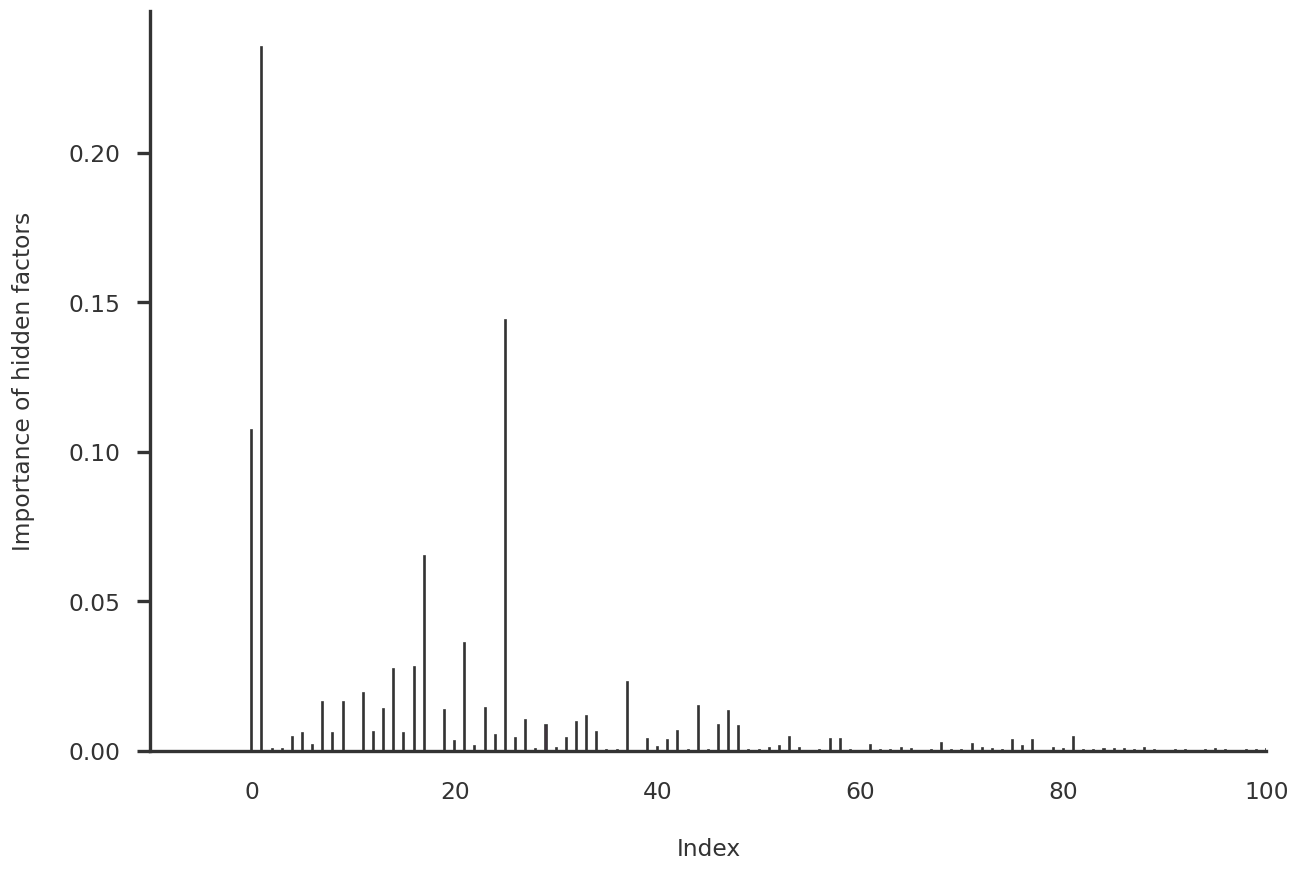

In [15]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)

loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps["nnm-sparse"]

xvals = np.arange(cos2_pheno.shape[1])
yvals = cos2_pheno[tidx, :]
ax1.bar(xvals, yvals, align = 'center', width = 0.1)

for side in ['top', 'right']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(bottom=False)
ax1.set_ylabel(f"Importance of hidden factors")
ax1.set_xlabel(f"Index")

ax1.set_xlim([-10, 100])

plt.show()

In [12]:
loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[methods[1]]

top_factor_dict = {i : list() for i in range(cos2_pheno.shape[0])}
for i, trait_name in enumerate(trait_df_noRx['description'].to_list()):
    top_factor = np.argsort(cos2_pheno[i, :])[::-1][0]
    top_factor_dict[top_factor].append(trait_name)
top_factor_dict

{0: ['A08 Viral and other specified intestinal infections',
  'B98 Other specified infectious agents as the cause of diseases classified to other chapters',
  'D13 Benign neoplasm of other and ill-defined parts of digestive system',
  'D22 Melanocytic naevi',
  'D23 Other benign neoplasms of skin',
  'E66 Obesity',
  'G47 Sleep disorders',
  'G93 Other disorders of brain',
  'H61 Other disorders of external ear',
  'H81 Disorders of vestibular function',
  'H90 Conductive and sensorineural hearing loss',
  'J30 Vasomotor and allergic rhinitis',
  'J31 Chronic rhinitis, nasopharyngitis and pharyngitis',
  'J93 Pneumothorax',
  'K13 Other diseases of lip and oral mucosa',
  'K14 Diseases of tongue',
  'K40 Inguinal hernia',
  'L03 Cellulitis',
  'M17 Gonarthrosis [arthrosis of knee]',
  'N60 Benign mammary dysplasia',
  'N89 Other noninflammatory disorders of vagina',
  'N90 Other noninflammatory disorders of vulva and perineum',
  'N99 Postprocedural disorders of genito-urinary system, 

In [17]:
import requests
import json

def get_opentarget_score(gene_id):

    # Build query string to get association information
    query_string = """
        query TargetAssociationsQuery(
          $ensemblId: String!
          $filter: String
          $sortBy: String!
          $enableIndirect: Boolean!
        ) {
          target(ensemblId: $ensemblId) {
            id
            approvedSymbol
            associatedDiseases(
              orderByScore: $sortBy
              BFilter: $filter
              enableIndirect: $enableIndirect
            ) {
              count
              rows {
                disease {
                  id
                  name
                }
                score
              }
            }
          }
        }

    """

    # Set variables object of arguments to be passed to endpoint
    variables = {
        "ensemblId": gene_id, 
        "filter": focal_disease["opentarget_name"],
        "sortBy": "score",
        "enableIndirect": False
    }

    # Set base URL of GraphQL API endpoint
    base_url = "https://api.platform.opentargets.org/api/v4/graphql"
    # print (gene_id)

    # Perform POST request and check status code of response
    r = requests.post(base_url, json={"query": query_string, "variables": variables})
    # print(r.status_code)

    # Transform API response from JSON into Python dictionary and print in console
    api_response = json.loads(r.text)
    # print(api_response)

    score = 0.0
    if api_response['data']['target'] is not None:
        associated_diseases = api_response['data']['target']['associatedDiseases']['rows']
        for d in associated_diseases:
            if d['disease']['id'] == focal_disease["opentarget_id"]:
                score = d['score']
    # print(score)
    return score

def get_variant_names(df):
    vstr_list = list()
    for i in range(df.shape[0]):
        vstr = 'chr' + df.iloc[i][['chr', 'rsid', 'Gene_name']].astype('str').str.cat(sep=' | ')
        gene_id = df.iloc[i]['ensembl_gene_id']
        if not pd.isna(gene_id):
            assoc_score = get_opentarget_score(gene_id)
            vstr += f" | {assoc_score:.3f}"
        else:
            vstr += f" | NaN"
        vstr_list.append(vstr)
    return vstr_list

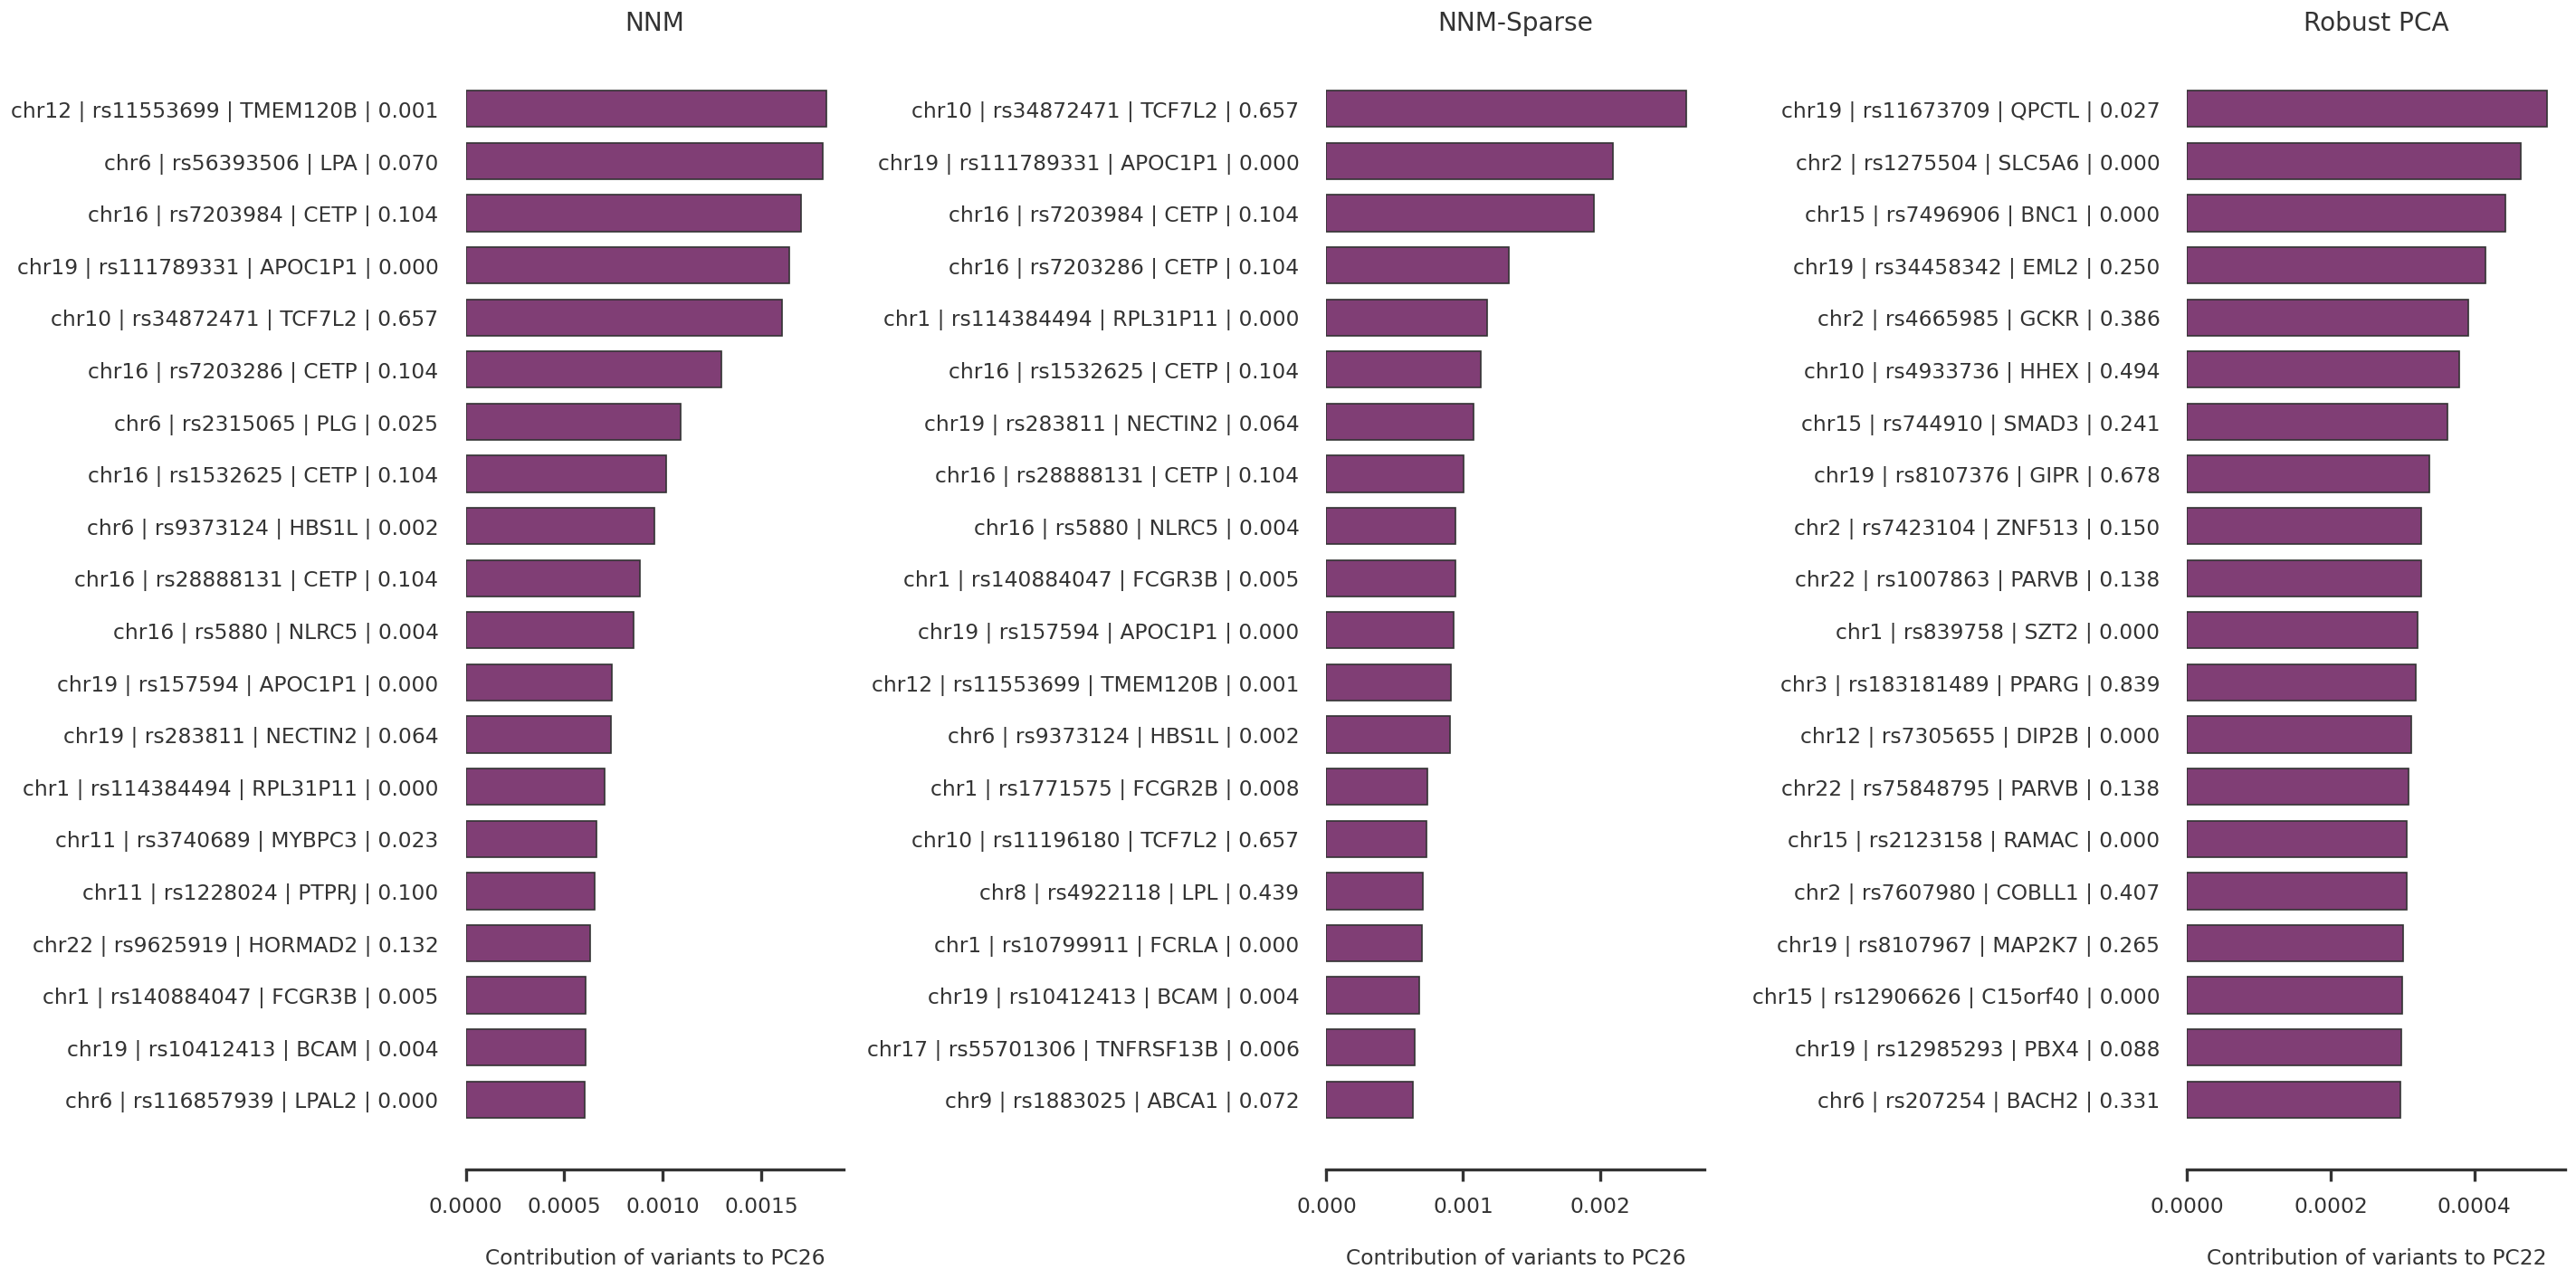

In [29]:
zindex = trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")["zindex"].values[0]

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

fig = plt.figure(figsize = (24, 12))
axs = dict()
for i, method in enumerate(methods):
    axs[method] = fig.add_subplot(1,3,i+1)
n_plot_variants = 20

for method in methods:
    loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]

    # top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][1]
    top_factor = np.argsort(cos2_pheno[tidx,2:])[::-1][0] + 2
    top_variant_idx = np.argsort(contribution_variant[:, top_factor])[::-1][:n_plot_variants]
    top_variant_df = variant_df.loc[zscore_df.index.to_numpy()[top_variant_idx]]
    top_variant_score = contribution_variant[top_variant_idx, top_factor]
    
    top_variant_names = get_variant_names(top_variant_df)
    
    xvals = top_variant_score
    yvals = np.arange(n_plot_variants)[::-1]

    axs[method].barh(yvals, xvals, align = 'center', height = 0.7)
    axs[method].set_yticks(yvals)
    axs[method].set_yticklabels(top_variant_names)

    for side in ['top', 'right', 'left']:
        axs[method].spines[side].set_visible(False)

    axs[method].tick_params(left=False)
    axs[method].set_xlabel(f"Contribution of variants to PC{top_factor + 1}")
    axs[method].set_title(method_names[method])

plt.tight_layout()
plt.show()

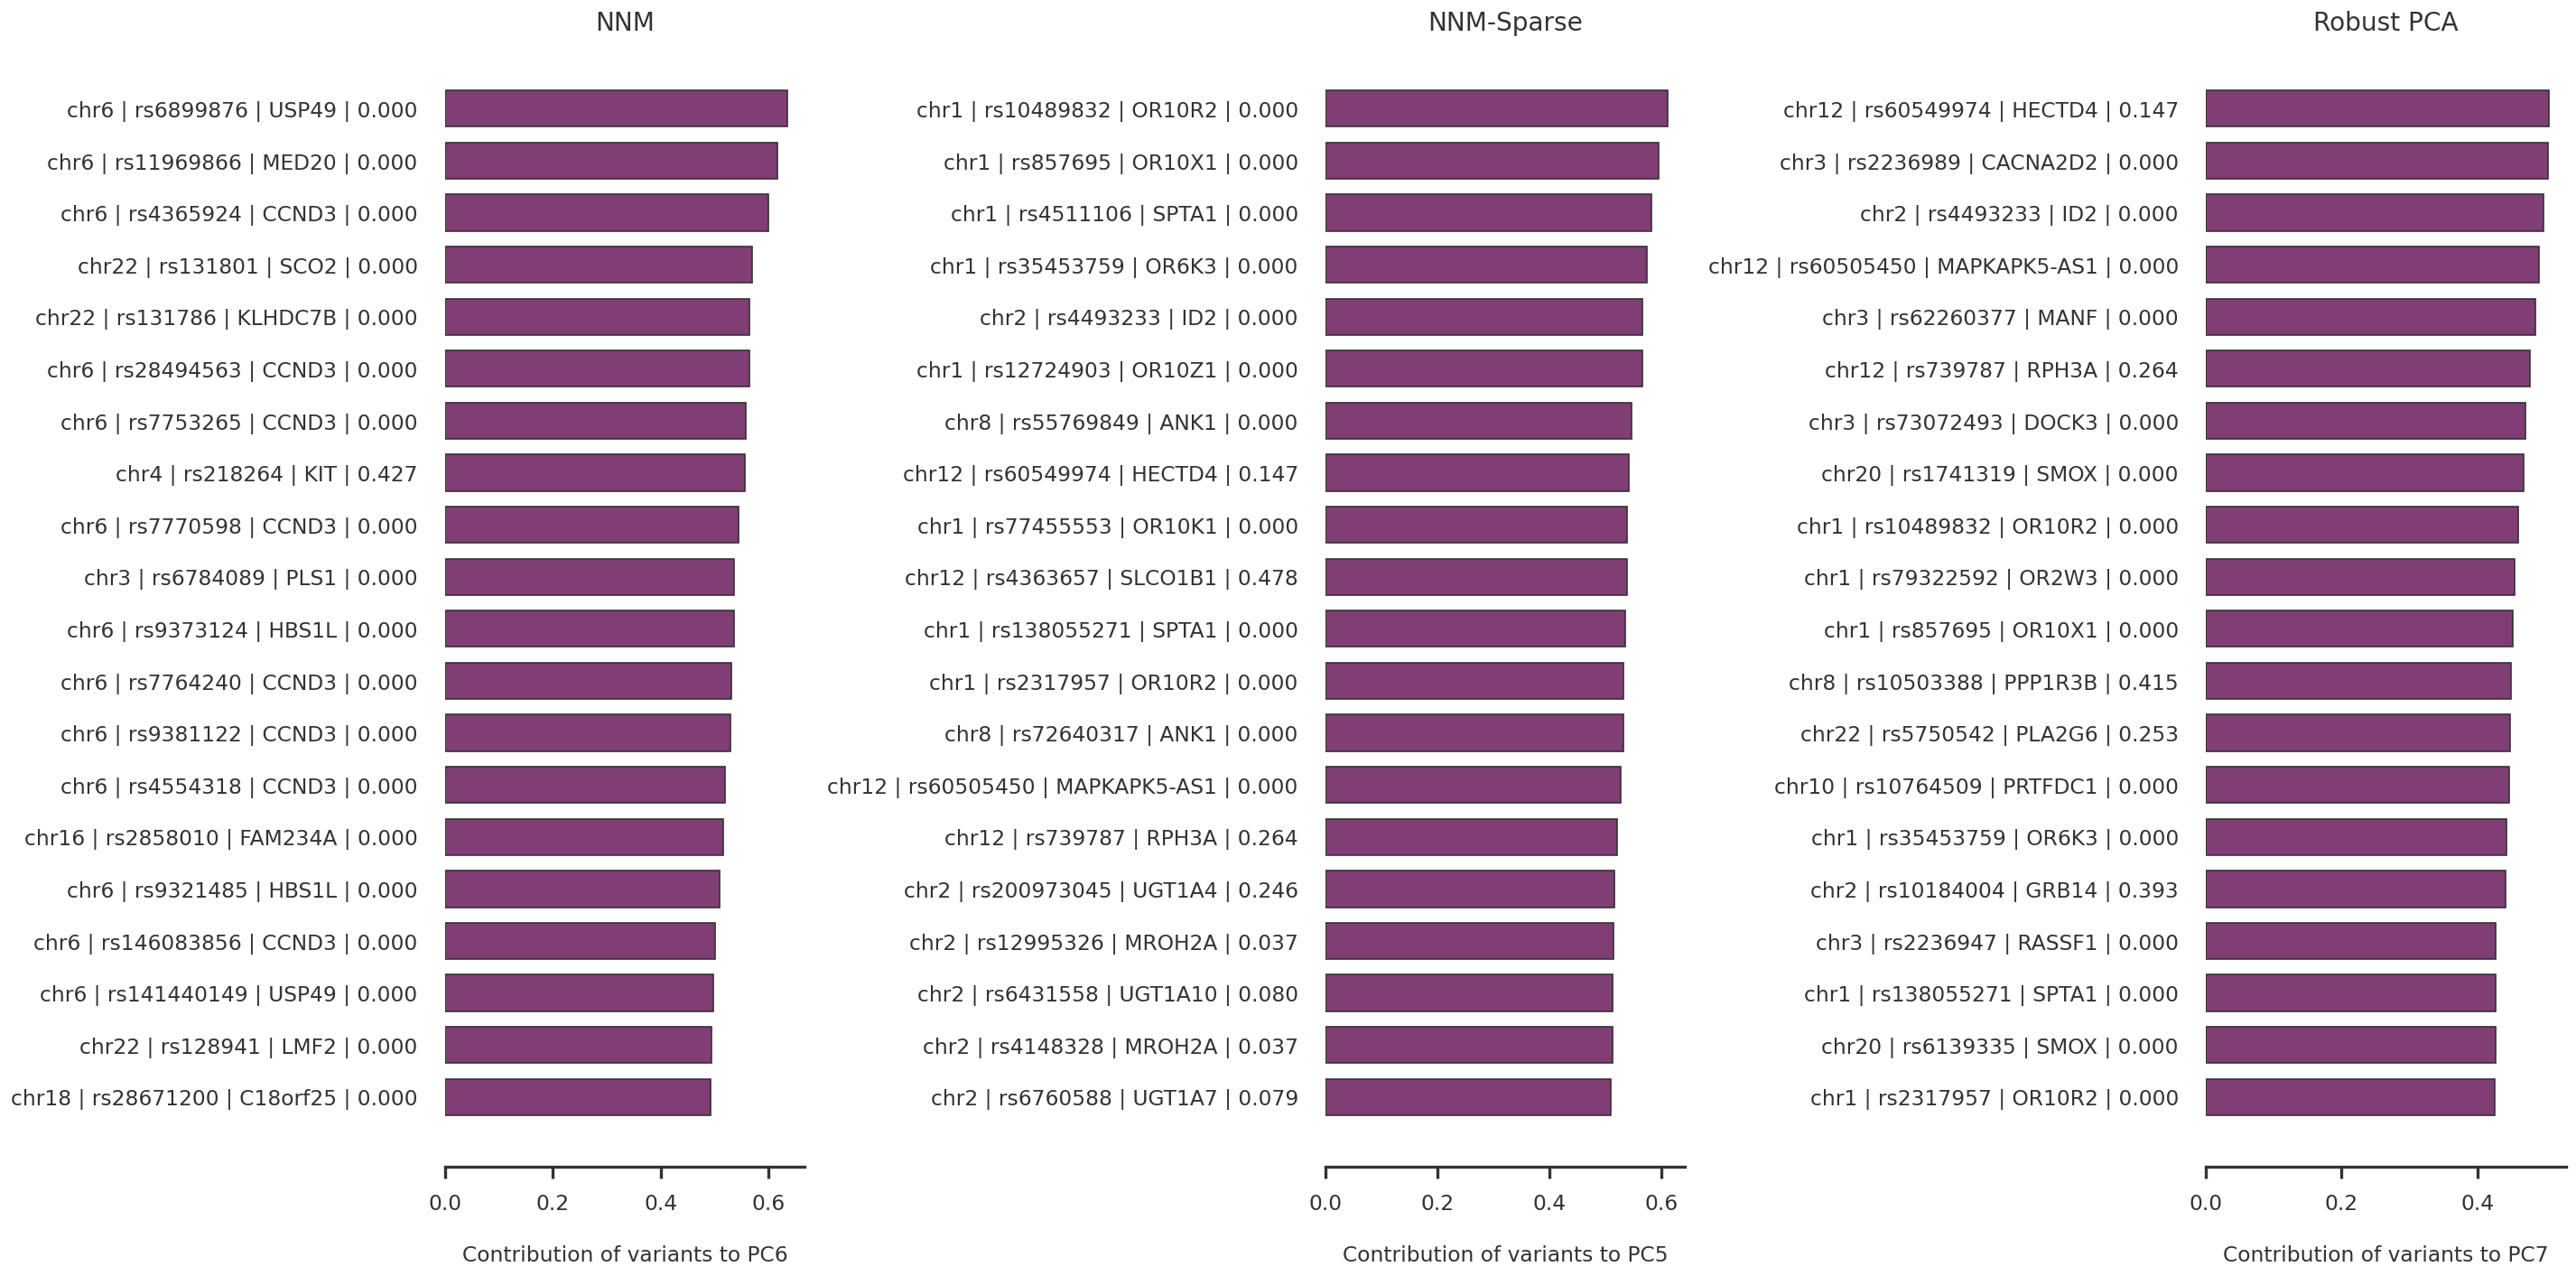

In [12]:
# zindex = trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")["zindex"].values[0]

# trait_indices = np.array(trait_df_noRx.index)
# tidx = np.searchsorted(trait_indices, zindex - 1)

# fig = plt.figure(figsize = (24, 12))
# axs = dict()
# for i, method in enumerate(methods):
#     axs[method] = fig.add_subplot(1,3,i+1)
# n_plot_variants = 20

# for method in methods:
#     loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
#     top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
#     kbest_models = SelectKBest(r_regression)
#     kbest_models.fit(X_cent, loadings[:, top_factor])
#     top_variant_idx = np.argsort(np.square(kbest_models.scores_))[::-1][:n_plot_variants]
#     top_variant_df = variant_df.loc[zscore_df.index.to_numpy()[top_variant_idx]]
#     top_variant_score = np.abs(kbest_models.scores_[top_variant_idx])
    
#     top_variant_names = get_variant_names(top_variant_df)
    
#     xvals = top_variant_score
#     yvals = np.arange(n_plot_variants)[::-1]

#     axs[method].barh(yvals, xvals, align = 'center', height = 0.7)
#     axs[method].set_yticks(yvals)
#     axs[method].set_yticklabels(top_variant_names)

#     for side in ['top', 'right', 'left']:
#         axs[method].spines[side].set_visible(False)

#     axs[method].tick_params(left=False)
#     axs[method].set_xlabel(f"Contribution of variants to PC{top_factor + 1}")
#     axs[method].set_title(method_names[method])

# plt.tight_layout()
# plt.show()

# Create summary statistics for LDSC regression

In [23]:
def create_sumstat(cos2_pheno, factors):
    pseudoN = np.sum(cos2_pheno * nsample_df_noRx.to_numpy(), axis = 0, keepdims = True)
    pseudoZ = factors * np.sqrt(pseudoN)
    return pseudoZ, pseudoN # p x k, n x 1

for method in methods:
    loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
    # top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][1]
    top_factor = np.argsort(cos2_pheno[tidx,2:])[::-1][0] + 2
    sumstat, pseudoN = create_sumstat(cos2_pheno, factors)
    varinfo = variant_df.loc[zscore_df.index][["SNP", "chr", "pos", "ref", "alt"]].rename(columns = {"chr": "CHR", "pos": "BP", "ref": "A1", "alt": "A2"})
    varinfo["N"] = pseudoN[0, top_factor]
    varinfo["Z"] = sumstat[:, top_factor]
    ss_filename = os.path.join(result_dir, method, "noRx", f"factor_{top_factor}_sumstat.gz")
    varinfo.to_csv(ss_filename, sep = "\t", header = True, index = False)

In [28]:
for method in methods:
    loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
    top_factor = np.argsort(cos2_pheno[tidx,2:])[::-1][0] + 2
    print (method, top_factor)

nnm 25
nnm-sparse 25
rpca 21


In [30]:
method = "nnm"
loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
# top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
top_factor = np.argsort(cos2_pheno[tidx,2:])[::-1][0] + 2
cts_resdir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/ldsc"
cts_resfile = os.path.join(cts_resdir, method, "enrich", f"factor_{top_factor}_sumstat.Multi_tissue_gene_expr.cell_type_results.txt")
cts_df = pd.read_csv(cts_resfile, sep="\t")
cts_df.sort_values(by=["Coefficient_P_value"]).head(10)

,Name,Coefficient,Coefficient_std_error,Coefficient_P_value
26,Pancreas,8.707244e-08,2.835589e-08,0.001068
104,A05.810.453.Kidney,7.871858e-08,2.620414e-08,0.001332
105,A03.620.Liver,8.191632e-08,2.966853e-08,0.002881
27,Liver,7.511038e-08,2.738385e-08,0.003045
182,A11.872.190.Embryonic.Stem.Cells,7.625980e-08,2.971629e-08,0.005140
28,Kidney_Cortex,7.265687e-08,2.943227e-08,0.006782
106,A03.556.124.369.Intestinal.Mucosa,8.779786e-08,3.585791e-08,0.007173
78,A03.556.249.124.Ileum,8.587089e-08,3.623170e-08,0.008893
0,Breast_Mammary_Tissue,5.427000e-08,2.302203e-08,0.009204
183,A10.165.114.830.750.Subcutaneous.Fat,5.582577e-08,2.404727e-08,0.010130


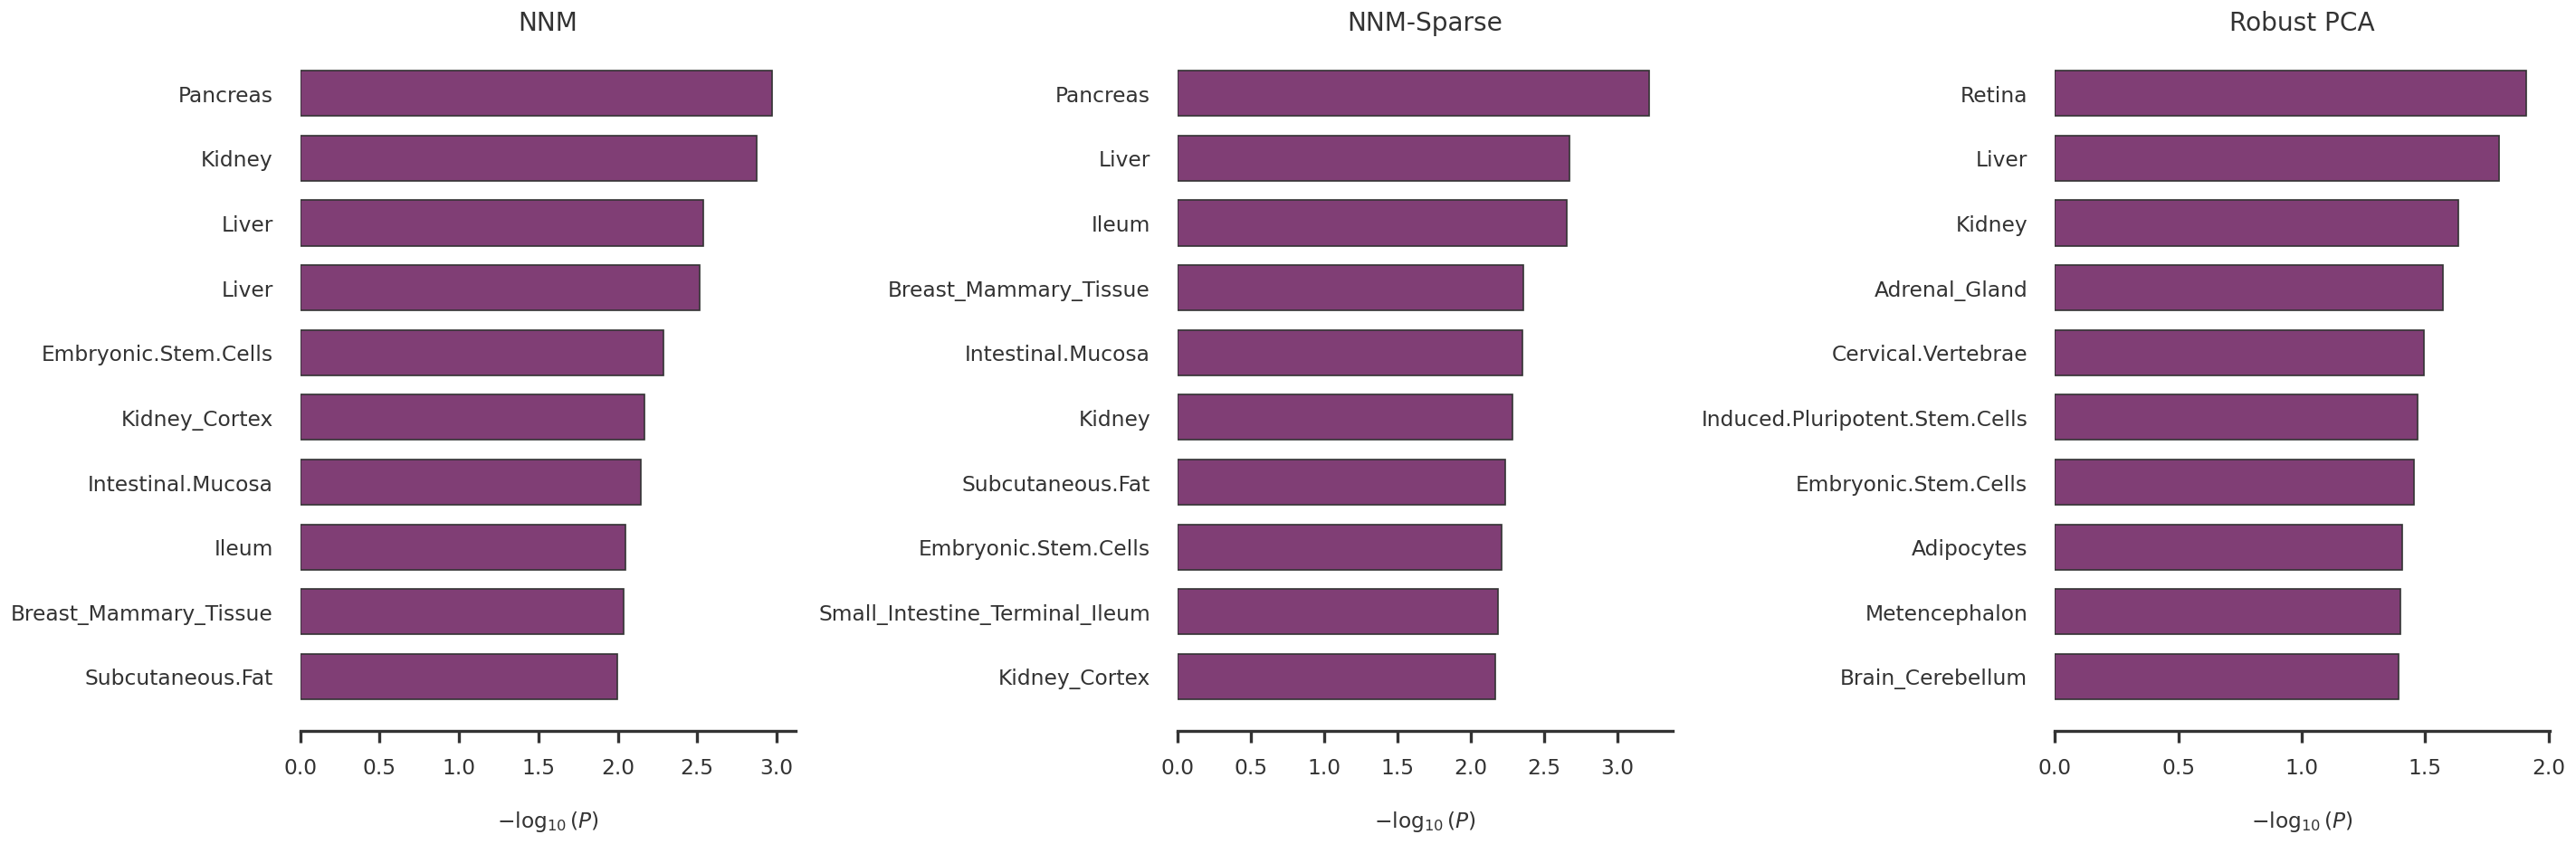

In [31]:
zindex = trait_df_noRx.query(f"description == '{focal_disease['df_query_string']}'")["zindex"].values[0]

trait_indices = np.array(trait_df_noRx.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

cts_resdir = "/gpfs/commons/home/sbanerjee/npddata/panukb/results/ldsc"

fig = plt.figure(figsize = (24, 8))
axs = dict()
for i, method in enumerate(methods):
    axs[method] = fig.add_subplot(1,3,i+1)
n_plot_tissues = 10

for method in methods:
    loadings, factors, cos2_pheno, cos2_variant, contribution_pheno, contribution_variant = mf_comps[method]
    # top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
    top_factor = np.argsort(cos2_pheno[tidx,2:])[::-1][0] + 2
    cts_resfile = os.path.join(cts_resdir, method, "enrich", f"factor_{top_factor}_sumstat.Multi_tissue_gene_expr.cell_type_results.txt")
    cts_df = pd.read_csv(cts_resfile, sep="\t").sort_values(by=["Coefficient_P_value"]).head(n_plot_tissues)
    
    xvals = -np.log10(cts_df["Coefficient_P_value"].to_numpy())
    yvals = np.arange(n_plot_tissues)[::-1]
    tissue_names = [re.sub(r'^\.*', '', re.sub(r'^A.*[0-9]+', '', x)) for x in cts_df["Name"].to_list()]

    axs[method].barh(yvals, xvals, align = 'center', height = 0.7)
    axs[method].set_yticks(yvals)
    axs[method].set_yticklabels(tissue_names)

    for side in ['top', 'right', 'left']:
        axs[method].spines[side].set_visible(False)

    axs[method].tick_params(left=False)
    axs[method].set_xlabel(r"$-\log_{10}(P)$")
    axs[method].set_title(method_names[method])

plt.tight_layout()
plt.show()